<a href="https://colab.research.google.com/github/DrVenkataRajeshKumar/S6/blob/master/images%20With%20L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [35]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:

import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
    # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) 
        

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8


        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 



    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)        
        x = self.convblock7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [37]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 10, 10]             576
             ReLU-11            [-1, 8, 10, 10]               0
      BatchNorm2d-12            [-1, 8, 10, 10]              16
          Dropout-13            [-1, 8, 10, 10]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [39]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

model =  Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.95, patience=0, verbose=True)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.11033716052770615 Batch_id=468 Accuracy=94.08: 100%|██████████| 469/469 [00:15<00:00, 29.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0547, Accuracy: 9827/10000 (98.27%)

EPOCH: 1


Loss=0.04343126341700554 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:14<00:00, 38.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9886/10000 (98.86%)

EPOCH: 2


Loss=0.01766946353018284 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:14<00:00, 32.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9913/10000 (99.13%)

EPOCH: 3


Loss=0.032145217061042786 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:14<00:00, 32.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9892/10000 (98.92%)

EPOCH: 4


Loss=0.06804663687944412 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:15<00:00, 30.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9931/10000 (99.31%)

EPOCH: 5


Loss=0.050508201122283936 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:15<00:00, 31.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9888/10000 (98.88%)

EPOCH: 6


Loss=0.012094165198504925 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:14<00:00, 31.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9907/10000 (99.07%)

EPOCH: 7


Loss=0.007270971778780222 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:14<00:00, 33.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9921/10000 (99.21%)

EPOCH: 8


Loss=0.10308936983346939 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:14<00:00, 31.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9935/10000 (99.35%)

EPOCH: 9


Loss=0.01920805312693119 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:14<00:00, 31.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9938/10000 (99.38%)

EPOCH: 10


Loss=0.04693193361163139 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:14<00:00, 31.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.01421026885509491 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:15<00:00, 31.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9940/10000 (99.40%)

EPOCH: 12


Loss=0.046113308519124985 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:15<00:00, 31.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9938/10000 (99.38%)

EPOCH: 13


Loss=0.03506234660744667 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 32.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9944/10000 (99.44%)

EPOCH: 14


Loss=0.03483292832970619 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:14<00:00, 31.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9932/10000 (99.32%)

EPOCH: 15


Loss=0.010697816498577595 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:15<00:00, 30.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9934/10000 (99.34%)

EPOCH: 16


Loss=0.0020219136495143175 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:14<00:00, 32.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9938/10000 (99.38%)

EPOCH: 17


Loss=0.0333099402487278 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:14<00:00, 31.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9942/10000 (99.42%)

EPOCH: 18


Loss=0.011170933954417706 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:15<00:00, 30.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9933/10000 (99.33%)

EPOCH: 19


Loss=0.015737533569335938 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 31.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9938/10000 (99.38%)

EPOCH: 20


Loss=0.17604507505893707 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:14<00:00, 32.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9940/10000 (99.40%)

EPOCH: 21


Loss=0.023919766768813133 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:14<00:00, 34.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9950/10000 (99.50%)

EPOCH: 22


Loss=0.0607338547706604 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:15<00:00, 30.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9943/10000 (99.43%)

EPOCH: 23


Loss=0.015009949915111065 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:15<00:00, 30.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9930/10000 (99.30%)

EPOCH: 24


Loss=0.08547725528478622 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:15<00:00, 31.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9944/10000 (99.44%)

EPOCH: 25


Loss=0.03950418159365654 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 31.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9949/10000 (99.49%)

EPOCH: 26


Loss=0.06657712906599045 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:14<00:00, 31.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9948/10000 (99.48%)

EPOCH: 27


Loss=0.01817520521581173 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:15<00:00, 31.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9951/10000 (99.51%)

EPOCH: 28


Loss=0.06799183785915375 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 31.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9943/10000 (99.43%)

EPOCH: 29


Loss=0.031935352832078934 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:15<00:00, 30.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0152, Accuracy: 9957/10000 (99.57%)

EPOCH: 30


Loss=0.009410698898136616 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:15<00:00, 30.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9947/10000 (99.47%)

EPOCH: 31


Loss=0.011859958060085773 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 30.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9946/10000 (99.46%)

EPOCH: 32


Loss=0.031088313087821007 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:15<00:00, 31.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9943/10000 (99.43%)

EPOCH: 33


Loss=0.00852375477552414 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 30.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9951/10000 (99.51%)

EPOCH: 34


Loss=0.008989910595119 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:15<00:00, 31.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9950/10000 (99.50%)

EPOCH: 35


Loss=0.034048836678266525 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:14<00:00, 31.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9944/10000 (99.44%)

EPOCH: 36


Loss=0.014701415784657001 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 37.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9946/10000 (99.46%)

EPOCH: 37


Loss=0.08986692875623703 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 30.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9946/10000 (99.46%)

EPOCH: 38


Loss=0.10143113136291504 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 31.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0142, Accuracy: 9956/10000 (99.56%)

EPOCH: 39


Loss=0.044785019010305405 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:14<00:00, 31.69it/s]



Test set: Average loss: 0.0176, Accuracy: 9946/10000 (99.46%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

Text(0.5, 1.0, 'Test Accuracy')

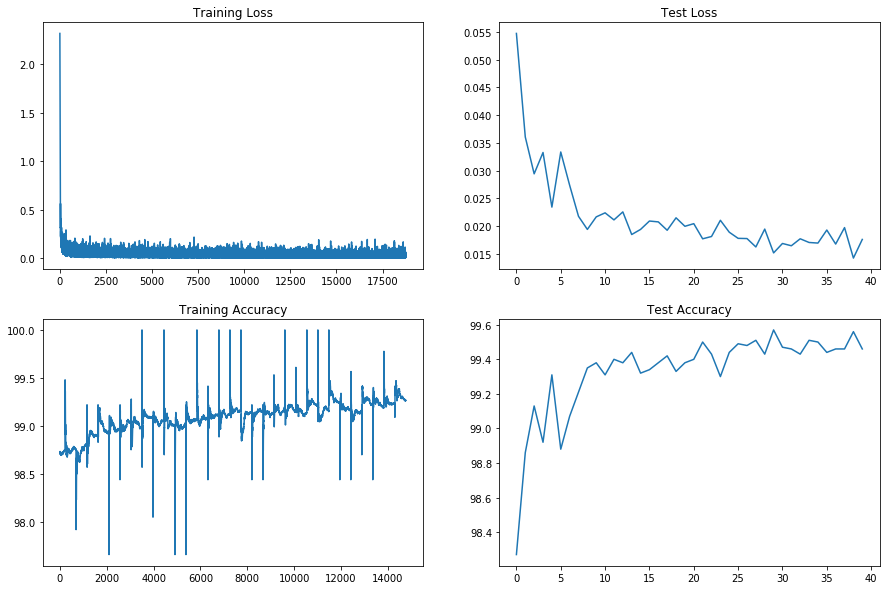

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

batchmates Mounika, Meenakshi, Vivek

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


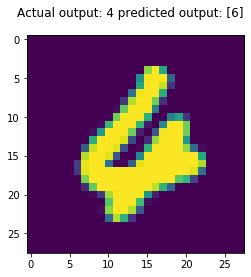

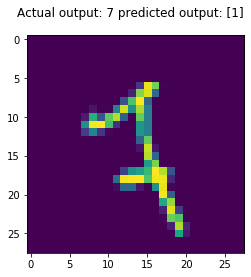

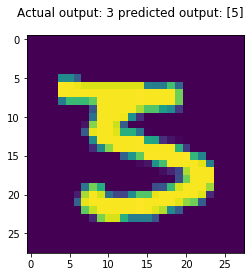

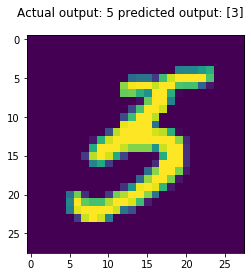

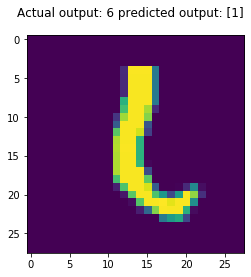

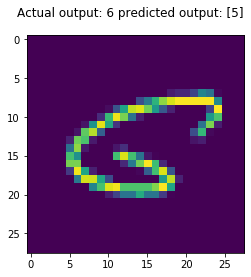

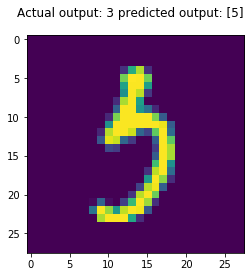

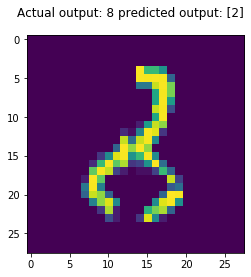

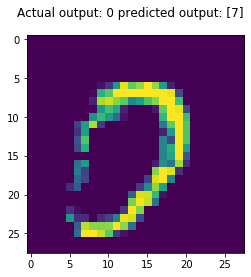

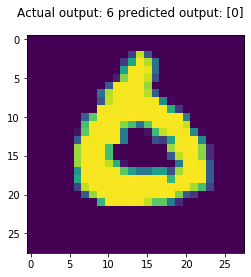

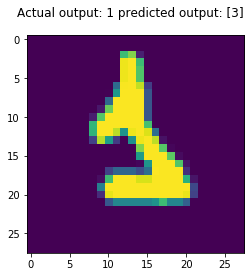

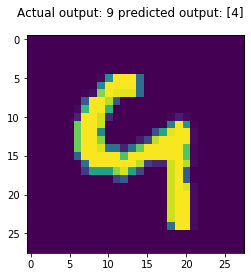

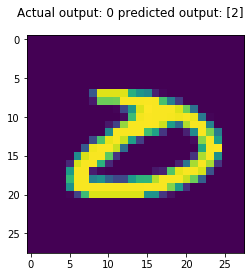

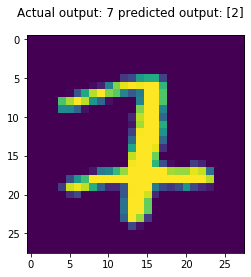

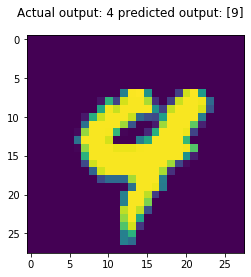

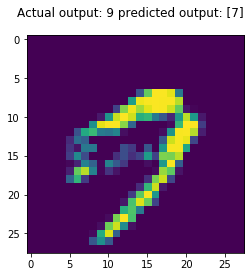

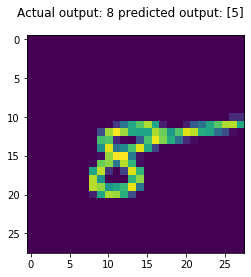

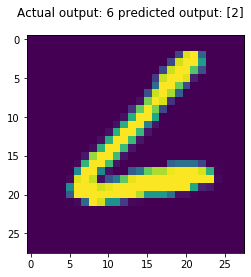

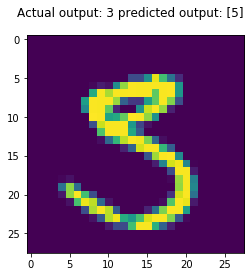

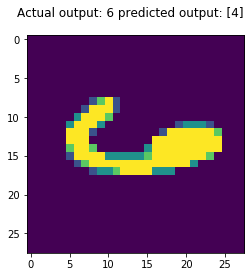

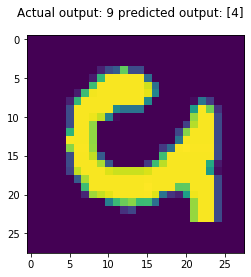

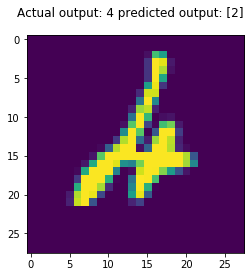

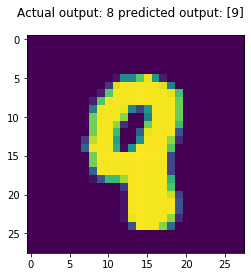

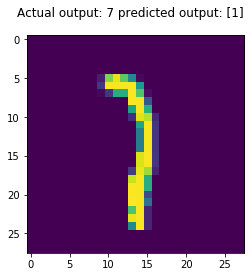

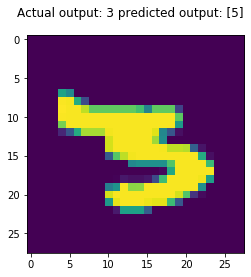

In [41]:
import numpy as np
import matplotlib.pyplot as plt

with torch.no_grad():
        count = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim= True)
            targetx = target.cpu().numpy()
            predx = pred.cpu().numpy()
            for i, j in enumerate(targetx):
              if count==25:
                break
              if targetx[i] != predx[i]:
                fig = plt.figure()
                plt.imshow(np.transpose(data[i].cpu().detach().numpy(), (1, 2, 0)).reshape(28,28))
                fig.suptitle("Actual output: " + str(targetx[i]) + " predicted output: " + str(predx[i]))

                count = count+1